<h1>Predict Complaint Types</h1>


The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

Add your answer to this question along with code and comments in a separate notebook. Upload the notebook in the subsection called "Question 4 - Can a predictive model be built for future prediction of the possibility of Complaints of the specific type that you identified in response to Question 1?" in the section "Submit your work and Review your Peer's work" in the module "Submit Your Work and Grade Your Peers".


In [1]:
#IMPORT THE LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import os

In [2]:
#FUNCTIONS DEFINED TO UPLOAD/DOWNLOAD TO OBJECT STORE

from ibm_botocore.client import Config
import ibm_boto3
def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Uploaded : ' + local_file_name)

from ibm_botocore.client import Config
import ibm_boto3

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

<h3>Download the Data</h3>

In [4]:
#DOWNLOAD THE FILE USING THE DEFINED FUNCTIONS ABOVE
download_file_cos(credentials,'311_ALL.pkl','311_ALL.pkl')

File Downloaded


In [5]:
#READ IN THE PICKLE FILE THAT WAS DOWNLOADED
df_311 = pd.read_pickle('311_ALL.pkl')

In [6]:
#CONVERT EVERYTHING TO UPPERCASE AND REMOVE ANY POSSIBLE SPACES IN FRONT OR BACK OF THE DATA
df_311['complaint_type'] = df_311['complaint_type'].str.upper() 
df_311['complaint_type'] = df_311['complaint_type'].str.strip()

df_311['incident_address'] = df_311['incident_address'].str.upper() 
df_311['incident_address'] = df_311['incident_address'].str.strip()

df_311['city'] = df_311['city'].str.upper() 
df_311['city'] = df_311['city'].str.strip()

#MAKE SURE THAT THE COMPLAINT_TYPES ALL MATCH. PAINT/PLASTER AND PAINT - PLASTER ARE THE SAME THING, SO WE WILL MAKE THEM A SINGLE CATAGORICAL VALUE
df_311['complaint_type'] = df_311['complaint_type'].str.replace('PAINT/PLASTER','PAINT - PLASTER')

#FIX THE ZIP CODES WHICH ARE FLOATS
df_311.incident_zip = df_311.incident_zip.fillna(0)
df_311.incident_zip = df_311.incident_zip.astype(int)

In [7]:
#FILTER OUT ONLY THE HEAT/HOT WATER SINCE WE DECIDED TO ONLY FOCUS ON THIS PER THE DIRECTIONS
df_311_Heat = df_311[df_311['complaint_type'].str.contains("HEAT/HOT WATER")]

In [8]:
#DEBUG
#df_311_Heat.head(5)

In [9]:
#DROP UNNEEDED COLUMNS
df_311_Heat = df_311_Heat.drop(['created_date', 'unique_key', 'resolution_description', 'closed_date', 'status', 'complaint_type'], axis=1)

In [10]:
#DEBUG
df_311_Heat.head(4)

,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,location_type
2,11417,86-07 SUTTER AVENUE,SUTTER AVENUE,ADDRESS,OZONE PARK,QUEENS,40.675885,-73.850473,RESIDENTIAL BUILDING
3,10002,575 GRAND STREET,GRAND STREET,ADDRESS,NEW YORK,MANHATTAN,40.713707,-73.979140,RESIDENTIAL BUILDING
4,11233,1711 FULTON STREET,FULTON STREET,ADDRESS,BROOKLYN,BROOKLYN,40.679340,-73.930435,RESIDENTIAL BUILDING
17,11236,1625 ROCKAWAY PARKWAY,ROCKAWAY PARKWAY,ADDRESS,BROOKLYN,BROOKLYN,40.641630,-73.898398,RESIDENTIAL BUILDING


In [11]:
#ADD A COUNT COLUMN
df_311_Heat['counts'] = 1

In [12]:
#DEBUG
#df_311_Heat.head(4)

In [13]:
#DOWNLOAD THE BRONX FILES
download_file_cos(credentials, 'BX_18v1.pkl', 'BX_18v1.pkl')
df_BX = pd.read_pickle('BX_18v1.pkl')

df_BX_reduced = df_BX[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                       'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']].copy()

df_BX_reduced.NumFloors = df_BX_reduced.NumFloors.astype(int)

#DELETE THE OLD DATAFRAME AND FREE MEMORY, AT LEAST IN THE PYTHON ENVIRONMENT, TO OTHER RESOURCES FOR OUR ENVIRONMENT
#TODO: POSSIBLE CALL TO GC?
del df_BX

#df_BX_reduced.head(4)

File Downloaded


In [14]:
#DOWNLOAD THE BROOKLYN FILES
download_file_cos(credentials, 'BK_18v1.pkl', 'BK_18v1.pkl')
df_BK = pd.read_pickle('BK_18v1.pkl')

df_BK_reduced = df_BK[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                       'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']].copy()

df_BK_reduced.NumFloors = df_BK_reduced.NumFloors.astype(int)

del df_BK

#df_BK_reduced.head(4)

File Downloaded


In [15]:
#DOWNLOAD THE MANHATTAN FILES
download_file_cos(credentials, 'MN_18v1.pkl', 'MN_18v1.pkl')
df_MN = pd.read_pickle('MN_18v1.pkl')

df_MN_reduced = df_MN[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                       'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']].copy()

df_MN_reduced.NumFloors = df_MN_reduced.NumFloors.astype(int)

del df_MN

#df_MN_reduced.head(4)

File Downloaded


In [16]:
#DOWNLOAD THE STATAN ISLAND FILES
download_file_cos(credentials, 'SI_18v1.pkl', 'SI_18v1.pkl')
df_SI = pd.read_pickle('SI_18v1.pkl')

df_SI_reduced = df_SI[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                       'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']].copy()

df_SI_reduced.NumFloors = df_SI_reduced.NumFloors.astype(int)

del df_SI

#df_MN_reduced.head(4)

File Downloaded


In [17]:
#DOWNLOAD THE QUEENS FILES
download_file_cos(credentials, 'QN_18v1.pkl', 'QN_18v1.pkl')
df_QN = pd.read_pickle('QN_18v1.pkl')

df_QN_reduced = df_QN[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 
                       'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']].copy()

df_QN_reduced.NumFloors = df_QN_reduced.NumFloors.astype(int)

del df_QN

#df_QN_reduced.head(4)

File Downloaded


In [18]:
#DEBUG
df_BX_reduced.head()

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1
0,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,0,0,0,6.02,0,0,0
1,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1,272,0,6.02,0,1931,1994
2,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2,0,0,6.02,0,1931,0
3,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5,0,12500,6.02,0,1931,2001
4,148 BRUCKNER BOULEVARD,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5,0,6876,6.02,1719,1920,2009


In [19]:
#APPEND ALL THE DATAFRAMES TOGETHER TO MAKE ONE LARGE ONE
df_BX_reduced = df_BX_reduced.append(df_BK_reduced, ignore_index=True)
df_BX_reduced = df_BX_reduced.append(df_SI_reduced, ignore_index=True)
df_BX_reduced = df_BX_reduced.append(df_MN_reduced, ignore_index=True)
df_BX_reduced = df_BX_reduced.append(df_QN_reduced, ignore_index=True)

In [20]:
#DEBUG : CHECK THE COUNT
df_BX_reduced.count()

Address       858700
BldgArea      859212
BldgDepth     859212
BuiltFAR      859212
CommFAR       859212
FacilFAR      859212
Lot           859212
LotArea       859212
LotDepth      859212
NumBldgs      859212
NumFloors     859212
OfficeArea    859212
ResArea       859212
ResidFAR      859212
RetailArea    859212
YearBuilt     859212
YearAlter1    859212
dtype: int64

In [21]:
#DEBUG
df_BX_reduced.head(3)

,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1
0,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,0,0,0,6.02,0,0,0
1,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1,272,0,6.02,0,1931,1994
2,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2,0,0,6.02,0,1931,0


<h3> df_BX_reduced contains all the data about the buidlings for all of New York</h3>

Now we will do some alterations and join the two dataframes based off address....

In [22]:
#GROUP THE COMPLAINTS BY THE ADDRESS, this should help reduce the data.
df_311_Heat_group = df_311_Heat.groupby(['incident_address']).count()['counts']

In [23]:
#RESET THE INDEX
df_311_Heat_group = df_311_Heat_group.reset_index()

In [24]:
#DEBUG
df_311_Heat_group.head(4)

,incident_address,counts
0,1 1 AVENUE,2
1,1 43 STREET,1
2,1 7 AVENUE,2
3,1 74 STREET,20


In [25]:
#JOIN THE 311 DATA WITH THE BUILDING DATA BASED ON THE ADDRESS. THIS WILL INCLUDE THE COUNT
joinedFinal = df_BX_reduced.set_index('Address').join(df_311_Heat_group.set_index('incident_address'))

In [26]:
#DEBUG
joinedFinal.sort_values(by=['counts'], ascending=False)

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,counts
1025 BOYNTON AVENUE,61500,87.00,4.99,0.0,4.8,54,12319,100.00,1,6,0,61500,2.43,0,1931,0,5208.0
34 ARDEN STREET,58030,88.00,3.01,0.0,6.5,175,19250,130.00,1,5,0,58030,3.44,0,1920,1983,4926.0
9511 SHORE ROAD,115672,0.00,3.81,0.0,4.0,7502,30380,0.00,1,6,0,109472,4.00,0,1957,0,3977.0
2968 PERRY AVENUE,34320,88.00,4.80,0.0,3.0,19,7150,110.00,1,6,0,34320,3.00,0,1931,0,2300.0
888 GRAND CONCOURSE,122800,178.00,4.32,0.0,6.5,34,28444,188.55,1,6,8000,111800,6.02,3000,1931,0,2224.0
72-10 41 AVENUE,128535,171.92,3.90,0.0,3.0,10,33000,198.00,1,6,0,117927,3.00,0,1955,0,2100.0
2040 BRONXDALE AVENUE,55650,84.00,4.24,0.0,4.8,5,13115,170.25,1,6,0,55650,3.44,0,1937,0,1974.0
3810 BAILEY AVENUE,54001,92.00,2.53,0.0,4.8,7,21320,164.00,1,5,0,54000,3.44,0,1925,0,1940.0
2750 HOMECREST AVENUE,194425,163.00,3.62,0.0,4.8,10,53730,110.75,1,7,0,194425,2.43,0,1959,2013,1895.0
1030 BOYNTON AVENUE,66456,84.00,4.18,0.0,4.8,17,15900,100.00,1,6,0,66456,2.43,0,1930,1988,1880.0


In [27]:
#RESET THE INDEX
joinedFinal = joinedFinal.reset_index()

In [28]:
# DEBUG
joinedFinal.head(4)

,index,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,counts
0,****** 95 STREET,0,0.0,0.0,0.0,2.0,50,2330,100.00,0,0,0,0,0.90,0,0,0,NaN
1,- 302 BEVERLEY ROAD,5400,90.0,2.7,0.0,4.8,6,2000,100.00,1,3,0,5400,2.43,0,1931,0,NaN
2,-00 128 AVENUE,0,0.0,0.0,0.0,1.0,32,4455,44.71,0,0,0,0,0.50,0,0,0,NaN
3,-00 136 AVENUE,0,0.0,0.0,0.0,1.0,13,4000,100.00,0,0,0,0,0.50,0,0,0,NaN


In [29]:
#FIX THE ZIP CODES WHICH ARE FLOATS, AND FILL IN ANY null DATA WITH 0's
joinedFinal.counts = joinedFinal.counts.fillna(0)
joinedFinal.counts = joinedFinal.counts.astype(int)

In [30]:
#DEBUG
#joinedFinal.head(4)

In [31]:
#RENAME THE INDEX COLUMN TO ADDRESS (SIDE EFFECT OF RESET_INDEX)
joinedFinal = joinedFinal.rename(columns={"index":"Address"})

In [32]:
#FILTER ALL THE EVENTS THAT ARE GREATER THAN 0
joinedFinal = joinedFinal[joinedFinal.counts > 0]

In [33]:
joinedFinal = joinedFinal.drop(['Address'], axis=1)

In [34]:
#DEBUG
#joinedFinal.head(4)

In [35]:
#FILTER OUT THE DATA WHERE THE BUILDING AREA IS > 0, as well as numFloors and year built, which was skewing the data
joinedFinal = joinedFinal[joinedFinal.BldgArea > 0]
joinedFinal = joinedFinal[joinedFinal.NumFloors > 0]
joinedFinal = joinedFinal[joinedFinal.YearBuilt > 0]

<h3>We now have our working Dataset to create a predictive model</h3>

We will look at the data first...

In [36]:
#LOOK FOR ANOMOLIES...
joinedFinal.describe()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,counts
count,6.899000e+04,68990.000000,68990.000000,68990.000000,68990.000000,68990.000000,6.899000e+04,68990.000000,68990.000000,68990.000000,6.899000e+04,6.899000e+04,68990.000000,68990.000000,68990.000000,68990.000000,68990.000000
mean,2.051993e+04,66.417637,2.361531,0.333392,3.486858,168.824047,7.712204e+03,105.457033,1.233903,3.701754,1.289008e+03,1.663964e+04,2.437354,653.128308,1932.817336,417.112683,12.106450
std,9.207399e+04,44.902015,10.829801,1.407142,2.067559,952.236882,6.076251e+04,51.360125,1.349377,2.980188,2.901945e+04,6.064133e+04,1.865614,5339.052141,28.228465,810.956457,53.837194
min,1.990000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1800.000000,0.000000,1.000000
25%,2.424000e+03,46.000000,1.000000,0.000000,2.000000,16.000000,2.097000e+03,97.000000,1.000000,2.000000,0.000000e+00,2.010000e+03,1.250000,0.000000,1915.000000,0.000000,1.000000
50%,4.122000e+03,60.000000,1.780000,0.000000,3.000000,35.000000,2.600000e+03,100.000000,1.000000,3.000000,0.000000e+00,3.360000e+03,2.430000,0.000000,1927.000000,0.000000,3.000000
75%,1.363500e+04,82.000000,3.290000,0.000000,4.800000,57.000000,5.000000e+03,100.670000,1.000000,5.000000,0.000000e+00,1.097900e+04,3.440000,0.000000,1937.000000,0.000000,8.000000
max,1.343508e+07,7360.000000,2088.000000,15.000000,15.000000,9100.000000,7.492320e+06,4050.080000,142.000000,76.000000,2.202507e+06,8.367942e+06,12.000000,838890.000000,2018.000000,2017.000000,5208.000000


Let's try a non-linear regression

In [37]:
msk = np.random.rand(len(joinedFinal)) < 1
train = joinedFinal[msk]
#test = joinedFinal[~msk]

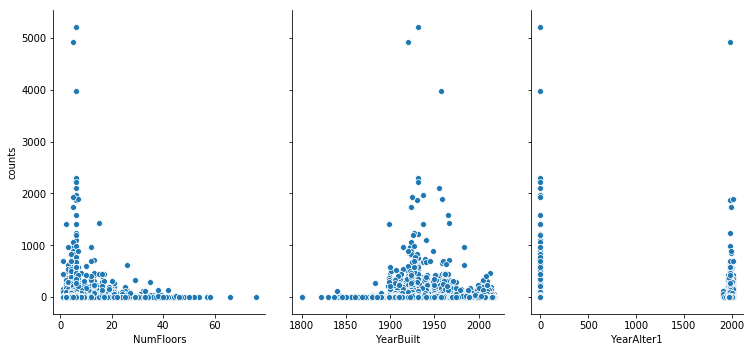

In [38]:
import seaborn as sns

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(train, x_vars=['NumFloors','YearBuilt','YearAlter1'], y_vars='counts', height=5, aspect=0.7)


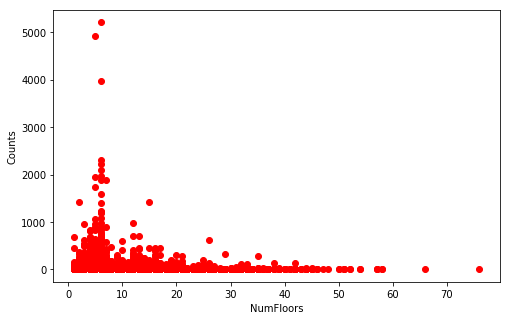

In [39]:
plt.figure(figsize=(8,5))
x_data, y_data = (train[['NumFloors']].values, train['counts'].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('Counts')
plt.xlabel('NumFloors')
plt.show()

In [40]:
finalFloors = train[['NumFloors','counts']]

In [41]:
#FINALFloors CONTAINS THE NUMBER OF FLOORS AND THE COMPLAINTS...
finalFloors.head(4)

,NumFloors,counts
32,1,2
34,6,20
38,5,109
42,4,1


In [42]:
#TRY THE AVERAGE PER FLOOR
finalFloors['TotalCount'] = finalFloors.groupby('NumFloors')['counts'].transform('mean')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [43]:
#WE DON'T NEED THE COUNTS ANYMORE BECAUSE WE HAVE THE AVERAGE
finalFloors = finalFloors.drop(['counts'], axis=1)

In [44]:
#DROP REPEATED ROWS
finalFloors = finalFloors.drop_duplicates().sort_values(by=['NumFloors'], ascending=True)



In [45]:
finalFloors = finalFloors.reset_index()


In [46]:
finalFloors = finalFloors.drop(['index'], axis=1)

In [47]:
finalFloors.head(4)

,NumFloors,TotalCount
0,1,3.803614
1,2,3.843030
2,3,5.768764
3,4,13.982016


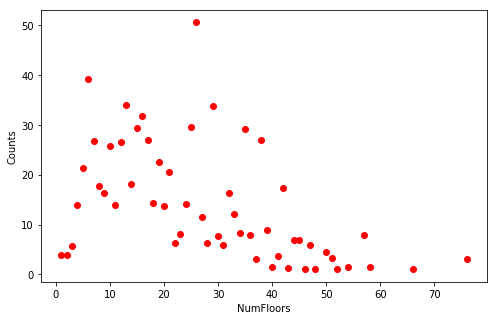

In [48]:
#GRAPH OUT THE AVERAGES
plt.figure(figsize=(8,5))
x_data, y_data = (finalFloors['NumFloors'].values, finalFloors['TotalCount'].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('Counts')
plt.xlabel('NumFloors')
plt.show()

In [49]:
# Lets normalize our data
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

In [50]:
def sigmoid(x, Beta_1, Beta_2):
     y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
     return y

In [51]:
y_data

array([ 3.80361388,  3.84302987,  5.76876356, 13.98201554, 21.439293  ,
       39.17308477, 26.75236806, 17.77903683, 16.352657  , 25.67407407,
       13.86597938, 26.63274336, 33.93233083, 18.10526316, 29.37815126,
       31.6918239 , 27.        , 14.25      , 22.56923077, 13.75      ,
       20.50909091,  6.26086957,  8.17857143, 14.17241379, 29.53333333,
       50.55      , 11.54545455,  6.4       , 33.81818182,  7.75      ,
        5.89473684, 16.36842105, 12.1875    ,  8.33333333, 29.07142857,
        8.        ,  3.        , 27.        ,  9.        ,  1.4       ,
        3.75      , 17.3       ,  1.33333333,  7.        ,  6.83333333,
        1.        ,  6.        ,  1.        ,  4.5       ,  3.33333333,
        1.        ,  1.5       ,  8.        ,  1.5       ,  1.        ,
        3.        ])

In [52]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(sigmoid, xdata, ydata, maxfev=1950)
#print the final parameters
print(" beta_1 = %f, beta_2 = %f" % (popt[0], popt[1]))

 beta_1 = 0.000009, beta_2 = 106255.855478


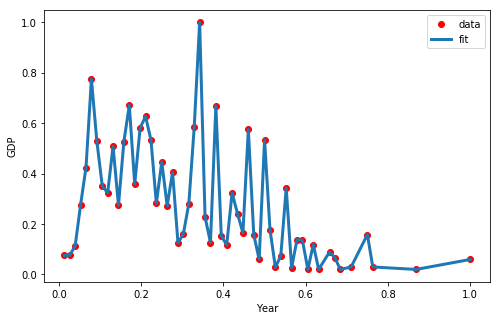

In [53]:
#x = np.linspace(1960, 2015, 55)
xdata2 = xdata/max(xdata)
plt.figure(figsize=(8,5))
y = sigmoid(xdata2, *popt)
plt.plot(xdata2, ydata, 'ro', label='data')
plt.plot(xdata2,ydata, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('GDP')
plt.xlabel('Year')
plt.show()

<h3>The model is overfit with sigmoid. Let's try gaussian</h3>

In [54]:
from numpy import exp, linspace, random

def gaussian(x, amp, cen, wid):
    return amp * exp(-(x-cen)**2 / wid)

In [55]:
msk = np.random.rand(len(finalFloors)) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata[msk]
test_y = ydata[~msk]

# build the model using train set
popt, pcov = curve_fit(gaussian, train_x, train_y)

# predict using test set
y_hat = gaussian(test_x, *popt)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

Mean absolute error: 0.13
Residual sum of squares (MSE): 0.03
R2-score: -0.48


<h3>The R2 score is negative. That means that it's probably better to just take the average. The conclusion is that num floors probably isn't the best for this model.</h3>

The questions for this notebook eluded to num floors being a predictor. All I have to say:

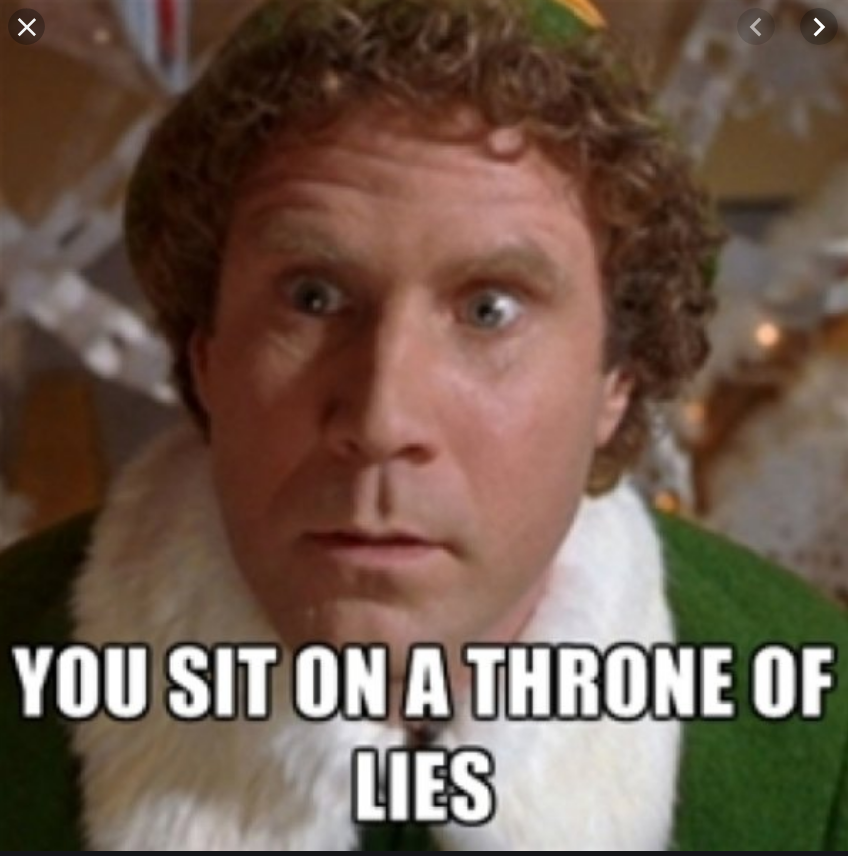

Let's try something else...

From the previous notebook, it appears that building height and if the building has been altered have a relationship to HEAT/HOT WATER issues. However, that might be due to data skew. For this exercise, let's table that for now.

In [56]:
finalYearBuilt = train[['YearBuilt','counts']]

In [57]:
#TRY THE AVERAGE PER FLOOR
finalYearBuilt['TotalCount'] = finalYearBuilt.groupby('YearBuilt')['counts'].transform('mean')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [58]:
#WE DON'T NEED THE COUNTS ANYMORE BECAUSE WE HAVE THE AVERAGE
finalYearBuilt = finalYearBuilt.drop(['counts'], axis=1)

In [59]:
#DEBUG:
#finalYearBuilt.head(4)

In [60]:
#DROP REPEATED ROWS
finalYearBuilt = finalYearBuilt.drop_duplicates().sort_values(by=['YearBuilt'], ascending=True)

In [61]:
#DEBUG
#finalYearBuilt.head(5)

In [62]:
finalYearBuilt = finalYearBuilt.reset_index()

In [63]:
finalYearBuilt = finalYearBuilt.drop(['index'], axis=1)

In [64]:
finalYearBuilt.head(5)

,YearBuilt,TotalCount
0,1800,1.727273
1,1822,4.000000
2,1830,3.666667
3,1836,1.000000
4,1838,2.000000


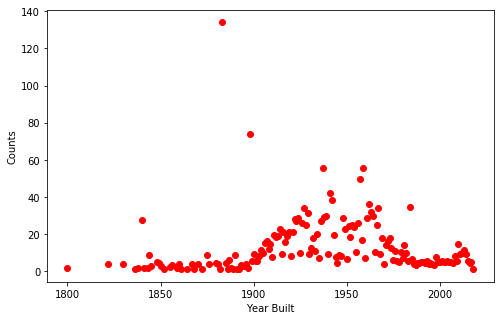

In [65]:
#GRAPH OUT THE AVERAGES
plt.figure(figsize=(8,5))
x_data, y_data = (finalYearBuilt['YearBuilt'].values, finalYearBuilt['TotalCount'].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('Counts')
plt.xlabel('Year Built')
plt.show()

In [66]:
# Lets normalize our data
xdata =x_data/max(x_data)
ydata =y_data/max(y_data)

In [67]:
msk = np.random.rand(len(finalYearBuilt)) < 0.8
train_x = xdata[msk]
test_x = xdata[~msk]
train_y = ydata[msk]
test_y = ydata[~msk]

# build the model using train set
popt, pcov = curve_fit(gaussian, train_x, train_y)

# predict using test set
y_hat = gaussian(test_x, *popt)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - test_y) ** 2))
from sklearn.metrics import r2_score
print("R2-score: %.2f" % r2_score(y_hat , test_y) )

Mean absolute error: 0.05
Residual sum of squares (MSE): 0.00
R2-score: -0.53


So close... maybe we could drop those outliers...

In [68]:
#SANITY FUNCTION
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [69]:
finalYearBuilt.head(3)

,YearBuilt,TotalCount
0,1800,1.727273
1,1822,4.000000
2,1830,3.666667


In [70]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(finalYearBuilt))
#print(z)

In [71]:
threshold = 4
print(np.where(z > 2))

(array([  0,   1,   2,  29,  42,  81, 101, 103]), array([0, 0, 0, 1, 1, 1, 1, 1]))


In [72]:
finalYearBuilt_removed = finalYearBuilt[(z < 1.8).all(axis=1)]

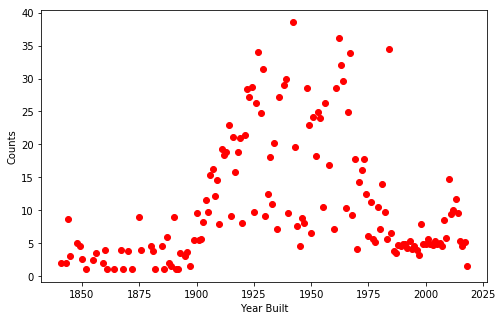

In [73]:
finalYearBuilt_removed

#GRAPH OUT THE AVERAGES
plt.figure(figsize=(8,5))
x_data, y_data = (finalYearBuilt_removed['YearBuilt'].values, finalYearBuilt_removed['TotalCount'].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('Counts')
plt.xlabel('Year Built')
plt.show()

In [74]:
finalYearBuilt_removed['Total_MA'] = finalYearBuilt_removed.TotalCount.rolling(window=10).mean()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [75]:
finalYearBuilt_removed.head(4)

,YearBuilt,TotalCount,Total_MA
6,1841,2.000000,NaN
7,1843,2.000000,NaN
8,1844,8.666667,NaN
9,1845,3.000000,NaN


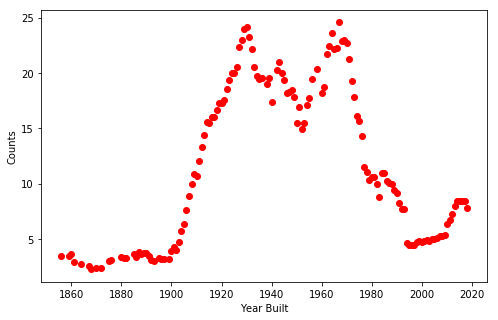

In [76]:
#GRAPH OUT THE AVERAGES
plt.figure(figsize=(8,5))
x_data, y_data = (finalYearBuilt_removed['YearBuilt'].values, finalYearBuilt_removed['Total_MA'].values)
plt.plot(x_data, y_data, 'ro')
plt.ylabel('Counts')
plt.xlabel('Year Built')
plt.show()

In [77]:
finalYearBuilt_removed.head(4)

,YearBuilt,TotalCount,Total_MA
6,1841,2.000000,NaN
7,1843,2.000000,NaN
8,1844,8.666667,NaN
9,1845,3.000000,NaN


In [78]:
finalYearBuilt_removed = finalYearBuilt_removed.dropna(thresh=3)

<h3>Standard linear regression</h3>

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
linear_model = LinearRegression(normalize=True)

In [99]:
X_linear=finalYearBuilt_removed.drop('TotalCount',axis=1)
X_linear=finalYearBuilt_removed.drop('Total_MA',axis=1)
y_linear=finalYearBuilt_removed['Total_MA']

In [100]:
linear_model.fit(X_linear,y_linear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [101]:
y_pred_linear = linear_model.predict(X_linear)

In [102]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))


In [103]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 57.90680197382616


In [104]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=finalYearBuilt_removed.drop('Total_MA',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
YearBuilt,0.021090
TotalCount,0.532617


In [106]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.5291955256218288


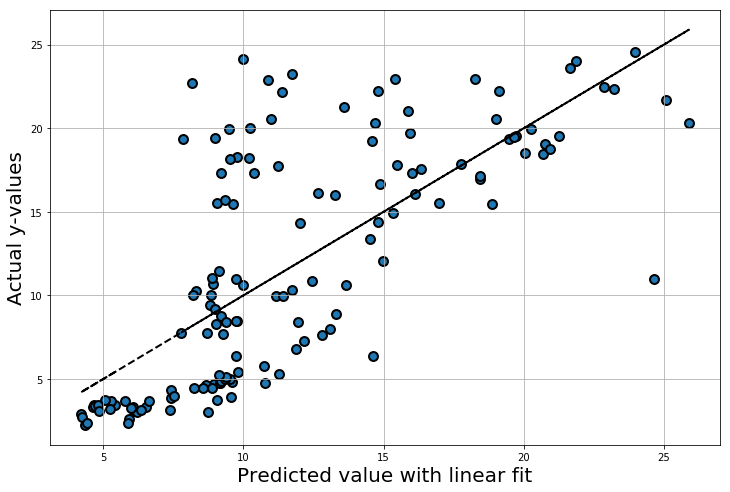

In [107]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)


Create polynomial features¶


In [108]:
from sklearn.preprocessing import PolynomialFeatures

In [109]:
poly = PolynomialFeatures(3,include_bias=False)

In [110]:


X_poly = poly.fit_transform(X_linear)
X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))



['Feature1', 'Feature2', 'Feature1^2', 'Feature1 Feature2', 'Feature2^2', 'Feature1^3', 'Feature1^2 Feature2', 'Feature1 Feature2^2', 'Feature2^3']
9


In [111]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature1^2,Feature1 Feature2,Feature2^2,Feature1^3,Feature1^2 Feature2,Feature1 Feature2^2,Feature2^3
0,1856.0,3.5,3444736.0,6496.0,12.25,6.393430e+09,12056576.0,22736.0,42.875
1,1859.0,2.0,3455881.0,3718.0,4.00,6.424483e+09,6911762.0,7436.0,8.000
2,1860.0,4.0,3459600.0,7440.0,16.00,6.434856e+09,13838400.0,29760.0,64.000
3,1861.0,1.0,3463321.0,1861.0,1.00,6.445240e+09,3463321.0,1861.0,1.000
4,1864.0,1.0,3474496.0,1864.0,1.00,6.476461e+09,3474496.0,1864.0,1.000


In [116]:
#finalYearBuilt_removed

df_poly['y']=finalYearBuilt_removed['Total_MA']
df_poly.head(5)



,Feature1,Feature2,Feature1^2,Feature1 Feature2,Feature2^2,Feature1^3,Feature1^2 Feature2,Feature1 Feature2^2,Feature2^3,y
0,1856.0,3.5,3444736.0,6496.0,12.25,6.393430e+09,12056576.0,22736.0,42.875,NaN
1,1859.0,2.0,3455881.0,3718.0,4.00,6.424483e+09,6911762.0,7436.0,8.000,NaN
2,1860.0,4.0,3459600.0,7440.0,16.00,6.434856e+09,13838400.0,29760.0,64.000,NaN
3,1861.0,1.0,3463321.0,1861.0,1.00,6.445240e+09,3463321.0,1861.0,1.000,NaN
4,1864.0,1.0,3474496.0,1864.0,1.00,6.476461e+09,3474496.0,1864.0,1.000,NaN


In [135]:
df_poly = df_poly.dropna(thresh=10)

In [136]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

Polynomial model without regularization and cross-validation¶

In [137]:
poly = LinearRegression(normalize=True)

In [138]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)


Root-mean-square error of simple polynomial model: 28.30684567714245


In [140]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,-303.102727
Feature2,-249.062035
Feature1^2,0.159461
Feature1 Feature2,0.251603
Feature2^2,0.045160
Feature1^3,-0.000028
Feature1^2 Feature2,-0.000064
Feature1 Feature2^2,-0.000018
Feature2^3,-0.000002


In [141]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 0.8734123428272043


<h3>Summary:</h3>

Using polynomial models we were able to predict at 87%, which in this case would likely be acceptable. More advanced methods could be used to make it more accurate.

We built the model with "year built" as the variable. We filtered out outliers in the label, number of calls, via z score. Then converted it to a moving average. It should be noted that this model will predict on the moving average, and since we took that apporach, it might be worth looking into some sort of catagorizations, however, we stuck with a linear approach.